---



# <font color='#ECA702'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

In [1]:
#@title **Importar librerías**

# Manipulación de datos
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from zipfile import ZipFile

# Para la visualización de frames de los vídeos
from ipywidgets import widgets, IntSlider, interactive

# Nos permite reproducir audios y vídeos en el Notebook
import IPython.display as ipd

# Novedad - Para tratar con audios
import librosa
from sklearn.preprocessing import minmax_scale # Para un proceso de normalización

In [2]:
#@title **Funciones de visualización necesarias**

# Para audio
def show_waveplot(audio_path,label):
    x , sr = librosa.load(audio_path, sr = 48000)
    plt.figure(figsize=(20, 6))
    librosa.display.waveshow(x, sr=sr)
    plt.title(f"Waveplot: of Class: {label}")

def show_spectrogram(audio_path,label):
    x , sr = librosa.load(audio_path, sr = 48000)
    # The STFT represents a signal in the time-frequency domain by computing
    # discrete Fourier transforms (DFT) over short overlapping windows.
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(f"Spectrogram of Class: {label}")

def show_zcr(audio_path,label):
    x , sr = librosa.load(audio_path, sr = 48000)
    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title(f'Zero Crossing Rate of Class: {label}')
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def show_spectral_centroids(audio_path,label):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Centroids of Class: {label}')
    x , sr = librosa.load(audio_path, sr = 48000)
    spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.show()

def show_spectral_rolloff(audio_path,label):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Rolloff of Class: {label}')
    x , sr = librosa.load(audio_path, sr = 48000)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=x, sr=sr, roll_percent=0.01)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.show()

def show_mfccs(audio_path,label):
    plt.figure(figsize=(20, 6))
    plt.title(f'MFCC of Class: {label}')
    x , sr = librosa.load(audio_path, sr = 48000)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

def show_melspectro(audio_path,label):
    plt.figure(figsize=(20, 6))
    plt.title(f'Mel Spectro of Class: {label}')
    x , sr = librosa.load(audio_path, sr = 48000)
    melspectro = librosa.feature.melspectrogram(y=x, sr=sr)
    librosa.display.specshow(melspectro, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

# <a name="tema1"> <font color='#4C5FDA'>**0. Comprendiendo el problema a tratar**</font> </a>

Logramos obtener un conjunto de datos de un conjunto de pacientes diagnosticados con Parkinson y pacientes de control.

La  <font color= "52F17F"> **enfermedad de Parkinson (EP)** </font> es una enfermedad neurodegenerativa crónica sin cura, caracterizada por una degeneración progresiva de las células nerviosas, disminuyendo la producción de dopamina, lo que resulta en graves alteraciones en el control del movimiento y la coordinación.

Las alteraciones motoras tempranas suelen manifestarse como <font color="EB9A54">**disartria**</font> (afectación del habla asociada a rigidez de los músculos).

<center>
  <img src="https://i.ytimg.com/vi/gD80xdT_uLE/maxresdefault.jpg" width="600" height="400">
</center>

E <font color="EB9A54">**hipomimia**</font> (afectación de la expresión facial asociada a lentitud de movimientos y rigidez).

<center>
  <img src="https://www.researchgate.net/publication/366948916/figure/fig1/AS:11431281160183154@1684634013197/Facial-expression-based-model-of-the-iPrognosis-app-for-detection-of-hypomimia-and.jpg" width="600" height="400">
</center>

Los pacientes con estos síntomas pueden experimentar dificultades para articular palabras o cambiar el tono de voz, lo que resulta en un habla difícil y monótona. Estos síntomas se manifiestan entre 7 y 11 años antes del diagnóstico de Parkinson. Hoy en día, estos patrones se caracterizan únicamente por pruebas observacionales, que dependen en gran medida de la experiencia del especialista.

La pregunta a responder es cómo podemos utilizar técnicas de análisis de video y audio para identificar patrones distintivos en los síntomas motores, como la rigidez facial y los trastornos del habla, y así desarrollar un enfoque multimodal que permita una detección precoz y precisa de la enfermedad, mejorando la calidad de vida de los pacientes y facilitando la planificación de tratamientos oportunos.

# <font color='#4C5FDA'> **1. ¡Exploremos nuestros datos! 😎**</color> <a name="tema2">


## <font color='#EB9A54'>**1.1 Carga de los datos**</font> <a name = "tema3">

<font color="52F17F">**Acerca del Dataset**</font>

La información recolectada por John se encuentra en carpetas separando entre paciendes de control y parkinson. En total se tienen 7 pacientes de control y 7 parkinson.

Para cada paciente se tienen vídeos con audio en los que las personas pronunciaron fonemas, vocales y palabras. La etiqueta ("yes" o "no" depediendo de si la persona tiene Parkison o es paciente de control) se obtiene a partir de la carpeta donde esté el registro.

Un <font color= "EB9A54"> **fonema** </font> es la unidad mínima de sonido que puede distinguir una palabra de otra en un lenguaje dado. En disartria, se estudian los patrones de producción y articulación de estos sonidos para detectar posibles alteraciones en el habla.

<font color='#52F17F'>**Lectura del Dataset**</font>

En el directorio `AudioVisualData_v7` podemos encontrar los vídeos para cada uno de los pacientes separada en casos con parkinson e imágenes de control. El cual tiene la siguiente estructura:

```
AudioVisualData_v7/
...Control/
......C0/
.........Phonemes/
............audio/
...............C0-1-Pakata.mp3
............frames/
...............C0-1-Pakata.mov/
..................000001.jpg
.........Vowels/
............audio/
...............C0-1-A.mp3
............frames/
...............C0-1-A.mov/
..................000001.jpg
.........Words/
............audio/
...............C0-1-Acariciar.mp3
............frames/
...............C0-1-Acariciar.mov/
..................000001.jpg
...Parkinson/
......P0/
.........Phonemes/
............audio/
...............P0-1-Pakata.mp3
............frames/
...............P0-1-Pakata.mov/
..................000001.jpg
.........Vowels/
............audio/
...............P0-1-A.mp3
............frames/
...............P0-1-A.mov/
..................000001.jpg
.........Words/
............audio/
...............P0-1-Acariciar.mp3
............frames/
...............P0-1-Acariciar.mov/
..................000001.jpg
```

Con `OS` y conociendo la estructura de nuestro dataset podemos armar un DataFrame de `pandas` para su análisis:


In [34]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


In [14]:
#@title **Extraer el zip**

target_path = os.path.join('../../../..') # Aquí es donde van a quedar los datos
# deben quedar fuera de drive para poder acceder a ellos 'localmente'

# Unzip the downloaded files
zip_file_path = os.path.join('AudioVisualData_v7.zip')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

%cd ../../../.. # Me muevo hasta donde quedaron los datos
%ls # Verifico

In [38]:
#@title **DataFrame con todos los registros**

# Directorio principal
main_directory = "AudioVisualData_v7"

patients = []
labels = []
frames = []
audios = []

"""
Esta construcción del dataset depende de la estructura del mismo
"""

# Itero por cada tipo de paciente: Control, Parkinson
for patient_type in os.listdir(main_directory):

  # A la ruta del directorio le concateno el tipo de paciente
  patient_type_path = os.path.join(f"{main_directory}/{patient_type}")

  # Itero por cada paciente en cada tipo de paciente
  for patient in os.listdir(patient_type_path):

    # A la ruta del tipo de paciente le concateno el paciente
    audio_type_path = os.path.join(f"{patient_type_path}/{patient}")

    # Itero por el tipo de sample: Phonemes, Vowels, Words
    for sample_type in os.listdir(audio_type_path):

      # Armo la ruta hasta el tipo de sample
      file_type_path = os.path.join(f"{audio_type_path}/{sample_type}")

      # Itero por cada registro en cada tipo de sample y le anaño audio a la ruta
      # para que entre de una vez a los registros
      for record in os.listdir(f"{file_type_path}/audio"):

        # Armo la ruta hasta el registro
        record_path = os.path.join(f"{file_type_path}/audio/{record}")
        # Agrego el paciente a la lista de pacientes
        patients.append(patient)
        # Agrego el label al final para asegurar que lo haga para cada paciente
        if patient_type == 'Parkinson':
          labels.append(1.)
        else:
          labels.append(0.)
        # Agrego la ruta del video
        frames.append(record_path.replace('audio', 'frames').replace('.mp3', '.mov'))
        # Agrego la ruta del audio
        audios.append(record_path)

# Crear un DataFrame con la información
data = pd.DataFrame({
    'patient': patients,
    'audio_path': audios,
    'frames_path': frames,
    'label': labels
})

data.set_index('patient', inplace=True)
data.head()

audio_path  \
patient                                                      
C5       AudioVisualData_v7/Control/C5/Phonemes/audio/C...   
C5       AudioVisualData_v7/Control/C5/Phonemes/audio/C...   
C5       AudioVisualData_v7/Control/C5/Phonemes/audio/C...   
C5       AudioVisualData_v7/Control/C5/Phonemes/audio/C...   
C5       AudioVisualData_v7/Control/C5/Phonemes/audio/C...   

                                               frames_path  label  
patient                                                            
C5       AudioVisualData_v7/Control/C5/Phonemes/frames/...    0.0  
C5       AudioVisualData_v7/Control/C5/Phonemes/frames/...    0.0  
C5       AudioVisualData_v7/Control/C5/Phonemes/frames/...    0.0  
C5       AudioVisualData_v7/Control/C5/Phonemes/frames/...    0.0  
C5       AudioVisualData_v7/Control/C5/Phonemes/frames/...    0.0

In [ ]:
#@title **Función para obtener una muestra**

def get_sample(tipo:float):

  sample = data[(data['label']==tipo)].sample(1)

  if tipo == 1.0:
    tipo = 'Parkinson'
  else:
    tipo = 'Control'
  sample = [sample['audio_path'].item(), sample['frames_path'].item(), tipo]
  return sample

## <font color='#EB9A54'>**1.2 Visualización de los datos**</font> <a name = "tema3">

In [ ]:
# Obtengo una muestra aleatoria para cada clase
parkinson = get_sample(1.0)
control = get_sample(0.0)

### <font color='#52F17F'>**Hipomimia (vídeos)**</font>

In [ ]:
def funcion(x, video_path: str):
    """
    Muestra una imagen específica de una secuencia de video.

    Args:
        x (int): El índice de la imagen en la secuencia de video. Se espera que las imágenes
                 estén nombradas secuencialmente con formato de seis dígitos, como '000001.jpg'.
        video_path (str): La ruta del directorio que contiene las imágenes de la secuencia de video.

    Returns:
        None: La función muestra la imagen especificada y el título de la imagen en una ventana de visualización.
    """

    # Cargar la imagen con el índice especificado, asegurando que el nombre del archivo tenga seis dígitos
    img = cv2.imread(f"{video_path}/"+"0"*(6-len(str(x)))+str(x)+".jpg")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(video_path.split('/')[-1])
    plt.show()

In [ ]:
#@title Muestra con hipomimia
slow = interactive(funcion, video_path=parkinson[1],x=widgets.IntSlider(min=1, max=100, step=1), continuous_update=True)
slow

In [ ]:
#@title Muestra sin hipomimia
slow = interactive(funcion, video_path=control[1],x=widgets.IntSlider(min=1, max=100, step=1), continuous_update=True)
slow

### <font color='#52F17F'>**Disartria (audios)**</font>

In [ ]:
#@title Muestra con disartria
ipd.Audio(parkinson[0])

In [ ]:
#@title Muestra sin disartria
ipd.Audio(control[0])

## <font color='#EB9A54'>**1.3 Análisis exploratorio**</font> <a name = "tema4">

### <a name = "tema5"> <font color="52F17F"> **1.2.1 Análisis del audio para la disartria** </font> </a>

Primero hay que definir algunas caracterísitcas descriptivas de las señales de sonido.

1. **Forma de onda (Waveform)**: Es una representación gráfica de una onda de sonido a medida que se mueve a través de un medio a lo largo del tiempo.

2. **Espectograma (Spectogram)**: Es una figura que representa el espectro de frecuencias de un audio grabado a lo largo del tiempo. Esto significa que a medida que el color de la figura se vuelve más brillante, el sonido se concentra en gran medida alrededor de esas frecuencias específicas, y a medida que el color se vuelve más oscuro, el sonido se acerca al sonido vacío/muerto.

3. **Tasa de cruce por cero (Zero crossing rate)**: La calificación de cruce por cero es el no. de veces que la señal cambia su valor de positivo a negativo o viceversa dividido por la longitud del cuadro.

4. **Centroide espectral (Spectral Centroid)**: Representa el centro de masa del espectro. Nos da la banda de frecuencia donde se concentra la mayor parte de la energía. Los centroides suelen estar altos cuando no hay voz y se vuelven bajos en aquellos casos en los que la voz está presente en el audio.

5. **Caída espectral (Spectral Roll-off)**: La caída espectral representa la frecuencia por debajo de la cual un cierto porcentaje (normalmente entre el 80 % y el 90 %, librosa: 85%) de la distribución de magnitud del espectro se concentra en el espectro.

6. **MFCC (Mel-frequency cepsral coefficients)**: Es una representación compacta del espectro de frecuencias de un audio. Se calcula en seis pasos y proporciona una representación de baja dimensión que captura las características más importantes del espectro de frecuencias.

<center>
  <img src="https://www.researchgate.net/publication/331275489/figure/fig2/AS:729006496292864@1550820101122/Steps-involved-in-MFCC-feature-extraction.png" width="600" height="400">
</center>

7. **Espectrograma Mel (Mel Spectrogram)**: Es un espectrograma donde las frecuencias se convierten a la escala Mel. La escala Mel muestra las magnitudes que son más perceptibles para el oído humano en general.

#### **Waveplots**


*   Para las muestra disártrica se puede observar que la muestra masculina tiene un habla arrastrada como es evidente en el diagrama de ondas.
*   Las muestras no disártricas tienen una gráfica de onda regular que indica un habla a un ritmo regular.



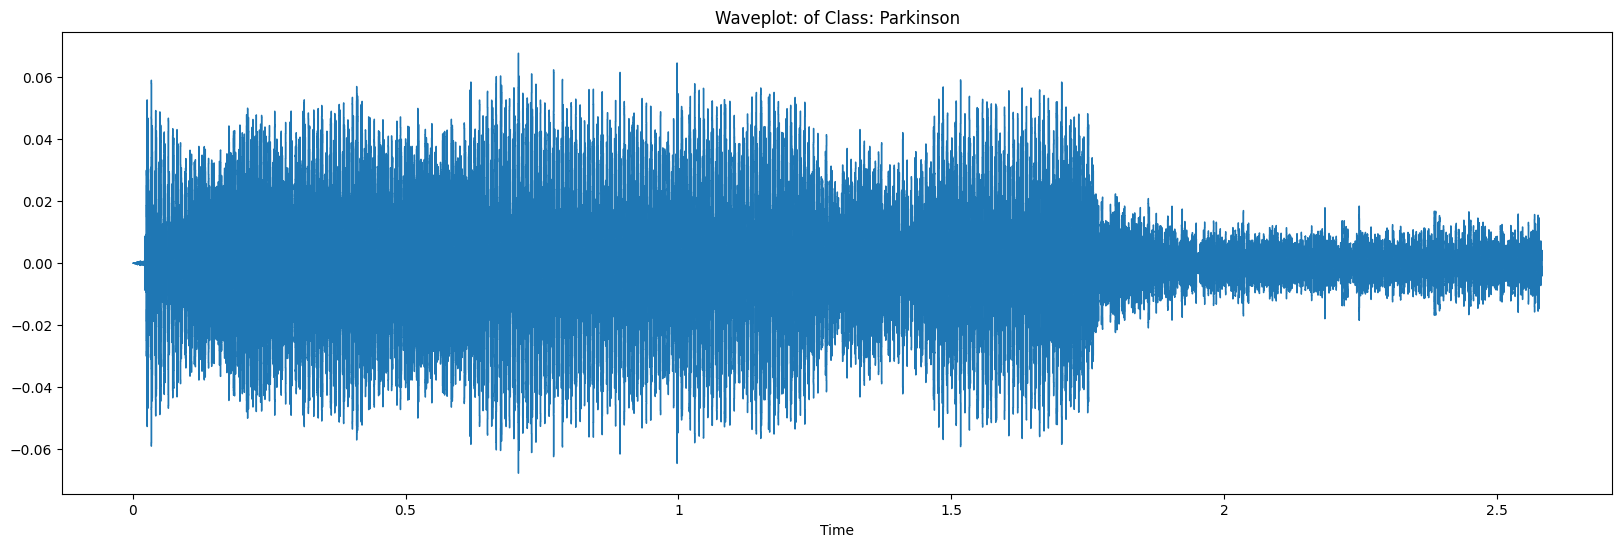

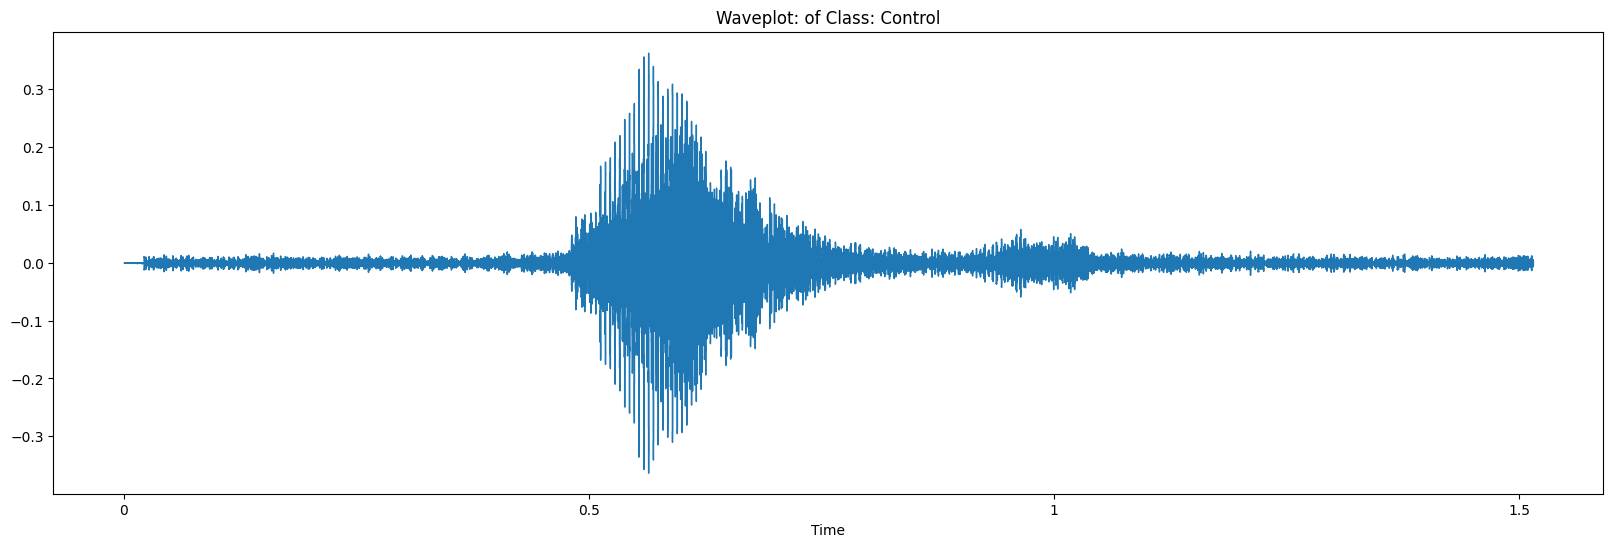

In [ ]:
show_waveplot(parkinson[0], parkinson[2])
show_waveplot(control[0], control[2])

#### **Spectrograms**


*   Para las muestras disártricas se puede ver que las magnitudes de energía de las frecuencias están más dispersas a lo largo del tiempo, lo que indica un habla lenta y confusa o debido al hecho de que las palabras salen más rápidamente y se superponen entre sí. También podrían ser posibles patrones similares para una persona disártrica y que habla de forma monótona.
*   Para las muestras no disártricas se puede ver que las magnitudes de energía están más reducidas a solo las partes donde han hablado algo, que es a un ritmo regular.



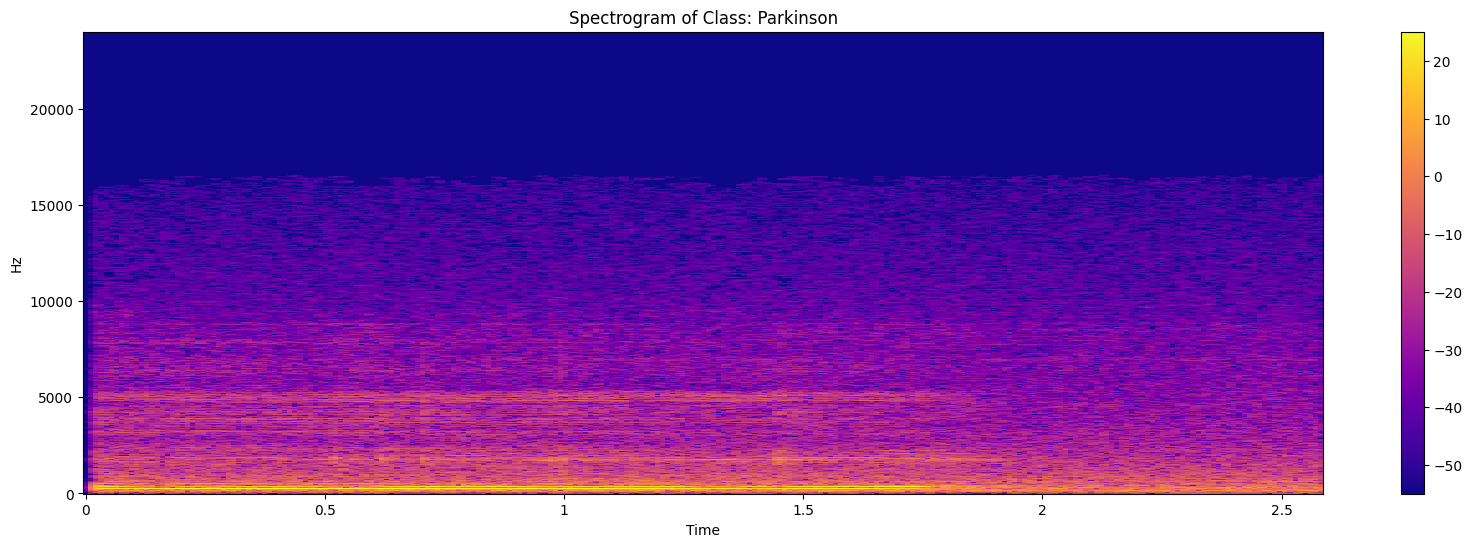

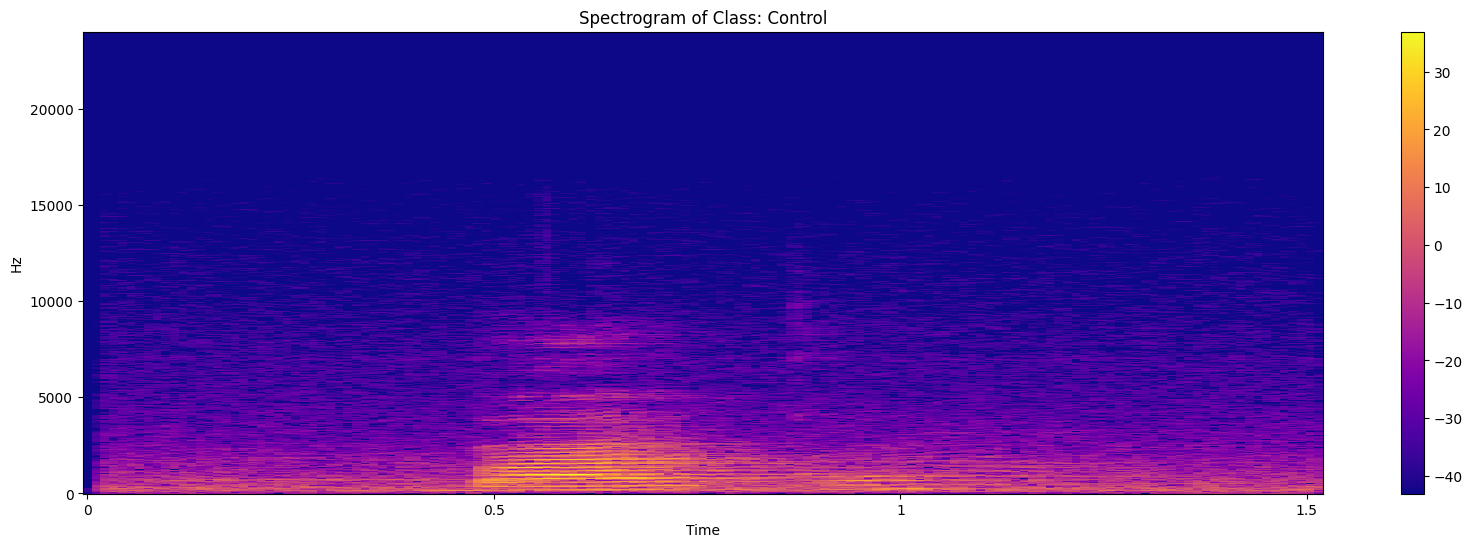

In [ ]:
show_spectrogram(parkinson[0], parkinson[2])
show_spectrogram(control[0], control[2])

#### **Zero Crossing Rate**


*   Para las muestras disártricas, se puede observar que en el audio mismo hubo casos en los que algunas de las frases de las palabras eran relativamente más fuertes y, por lo tanto, hay múltiples picos de tasa de cruce por cero en esos casos. Este volumen repentino de ciertas palabras podría deberse a su falta de control sobre la lengua y otros músculos relacionados con la boca mientras hablan y a no poder enfatizar las palabras intencionalmente.
*   Para los casos no disártricos, la tasa de cruce por cero es alta en aquellos casos en los que la voz del hablante es audible.



Sum of zero crossing  2672


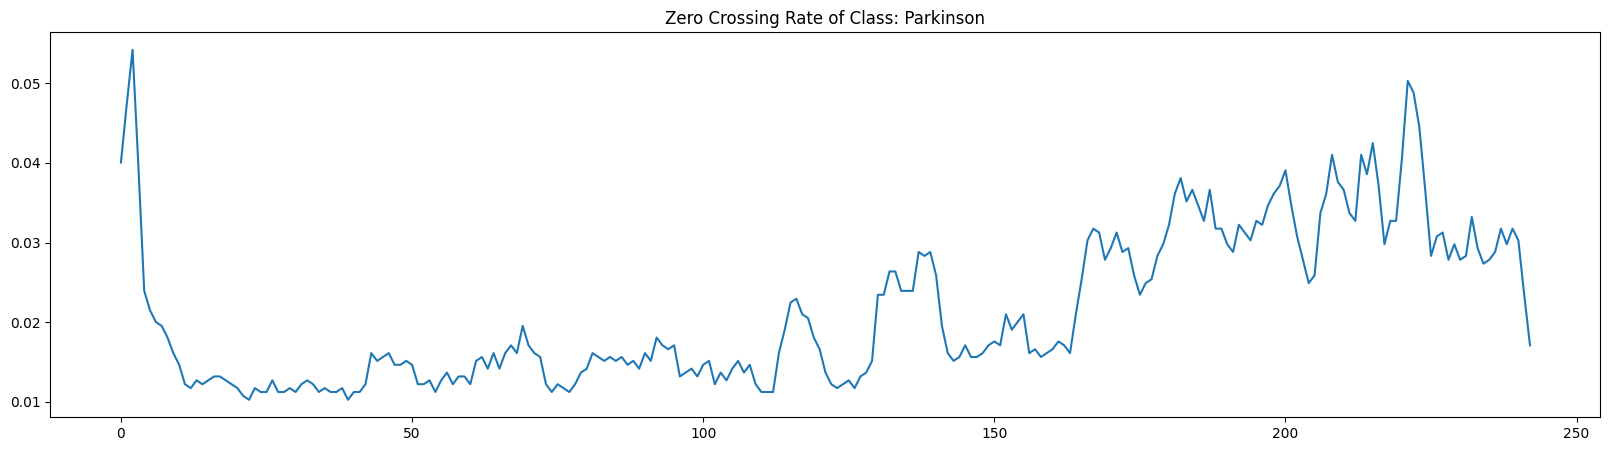

Sum of zero crossing  2617


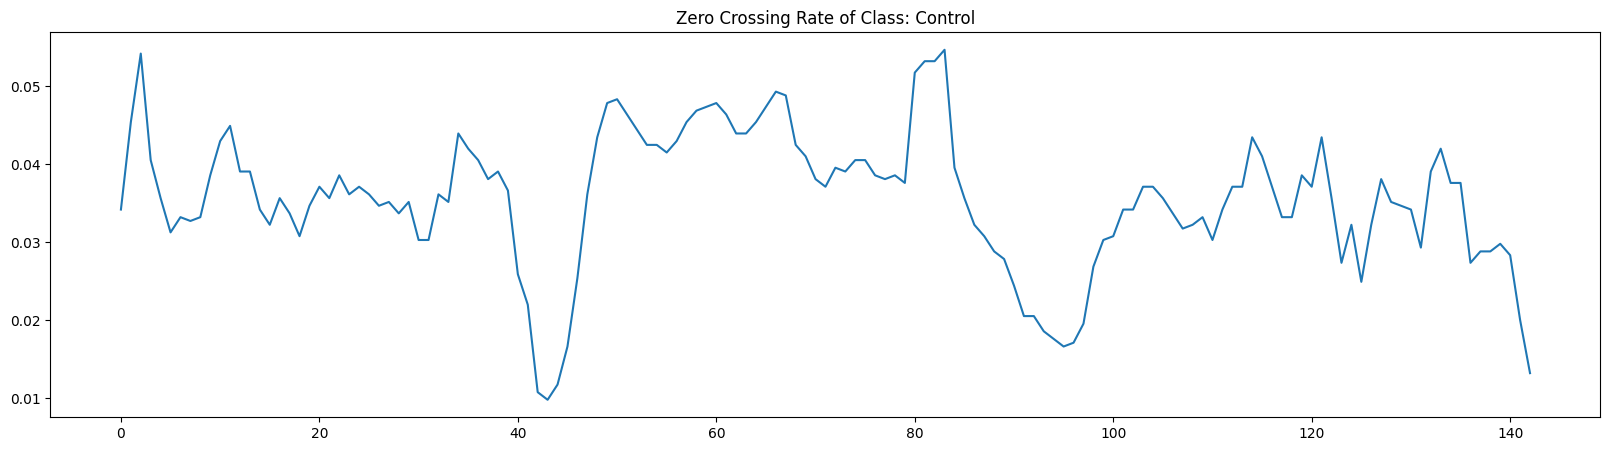

In [ ]:
show_zcr(parkinson[0], parkinson[2])
show_zcr(control[0], control[2])

#### **Spectral Centroid**


*   Para muestras disártricas se puede ver que debido a que el habla es confusa, los valores del centroide bajan por un tiempo y vuelven a subir tan pronto como hay algunas pequeñas pausas.
*   Para muestras no disártricas, los centroides están abajo por un momento cuando el habla está presente en el audio y vuelven a subir tan pronto como no hay voz en el audio.



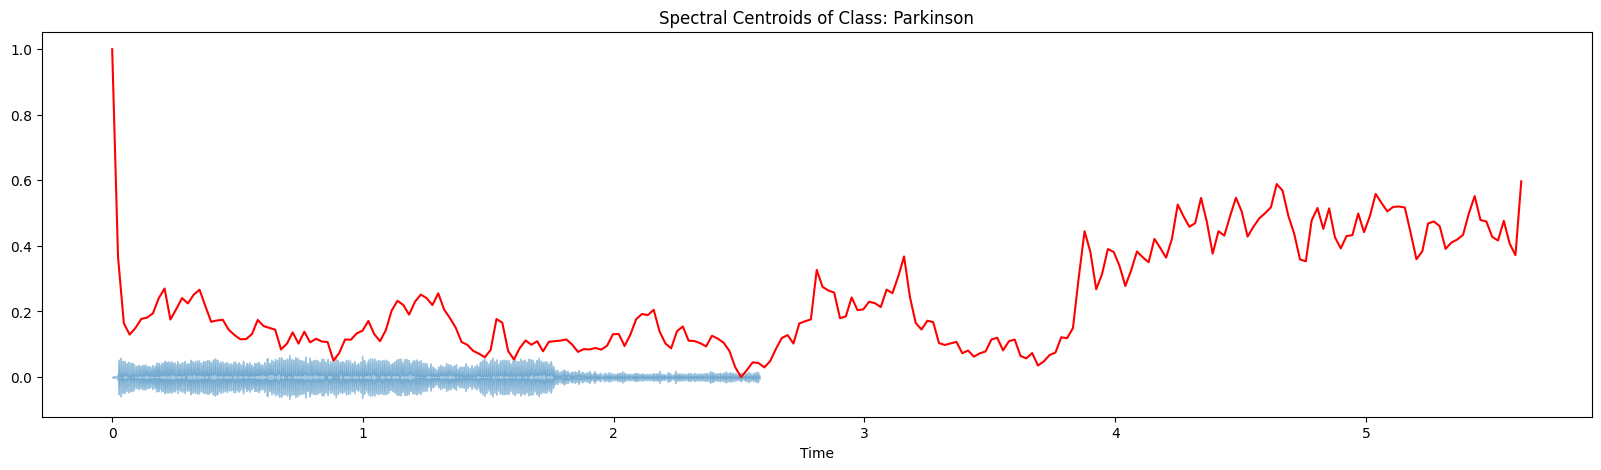

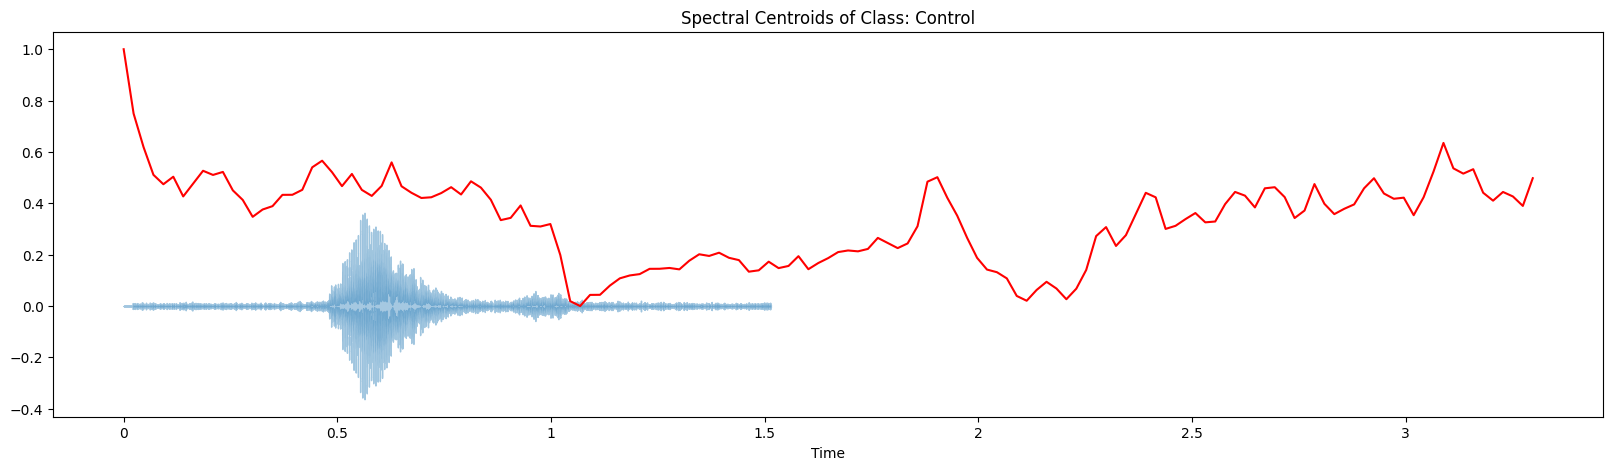

In [ ]:
show_spectral_centroids(parkinson[0], parkinson[2])
show_spectral_centroids(control[0], control[2])

#### **Spectral Rolloff**


*   Como habíamos observado anteriormente en los espectrogramas las magnitudes de energía de las frecuencias están más dispersas en el caso de muestras disártricas, se puede ver la cobertura del 85% por debajo de la frecuencia de caída envolviendo el habla presente en la señal de audio.
*   Para muestras no disártricas podemos ver que la cobertura del 85% incluye el habla así como algunas otras perturbaciones/ruido en el audio.



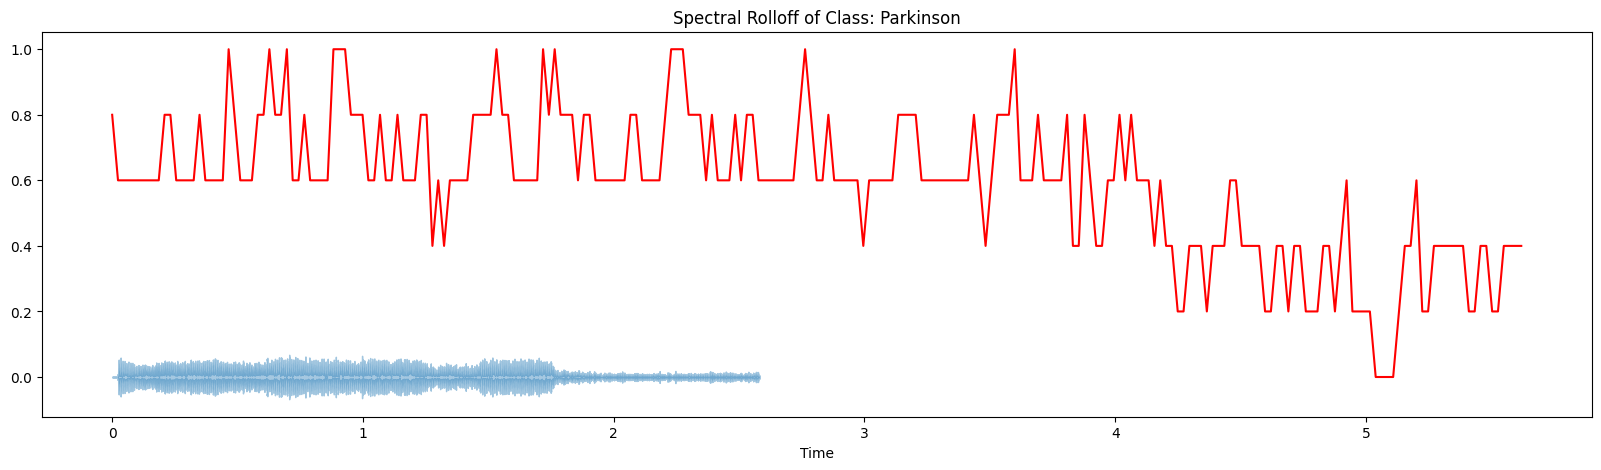

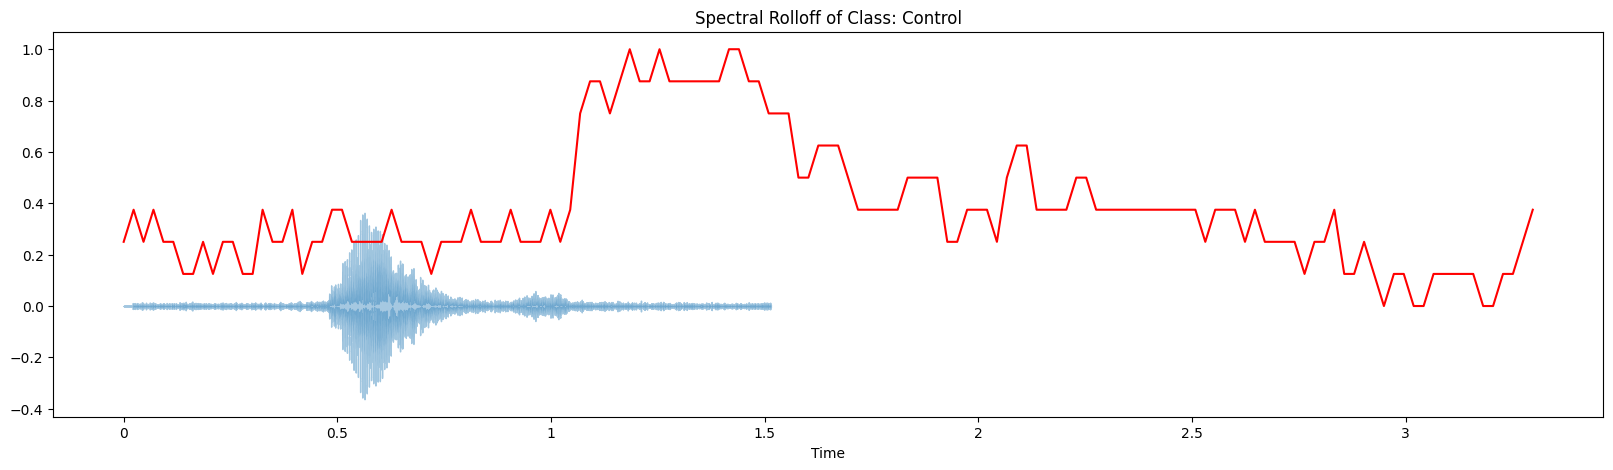

In [ ]:
show_spectral_rolloff(parkinson[0], parkinson[2])
show_spectral_rolloff(control[0], control[2])

#### **MFCCs**


*   Para muestras disártricas, la visualización de MFCC tiene píxeles mucho más oscuros y concentrados que indican los arrastres presentes en su habla.
*   Para los no disártricos no está tan concentrado y está más extendido.



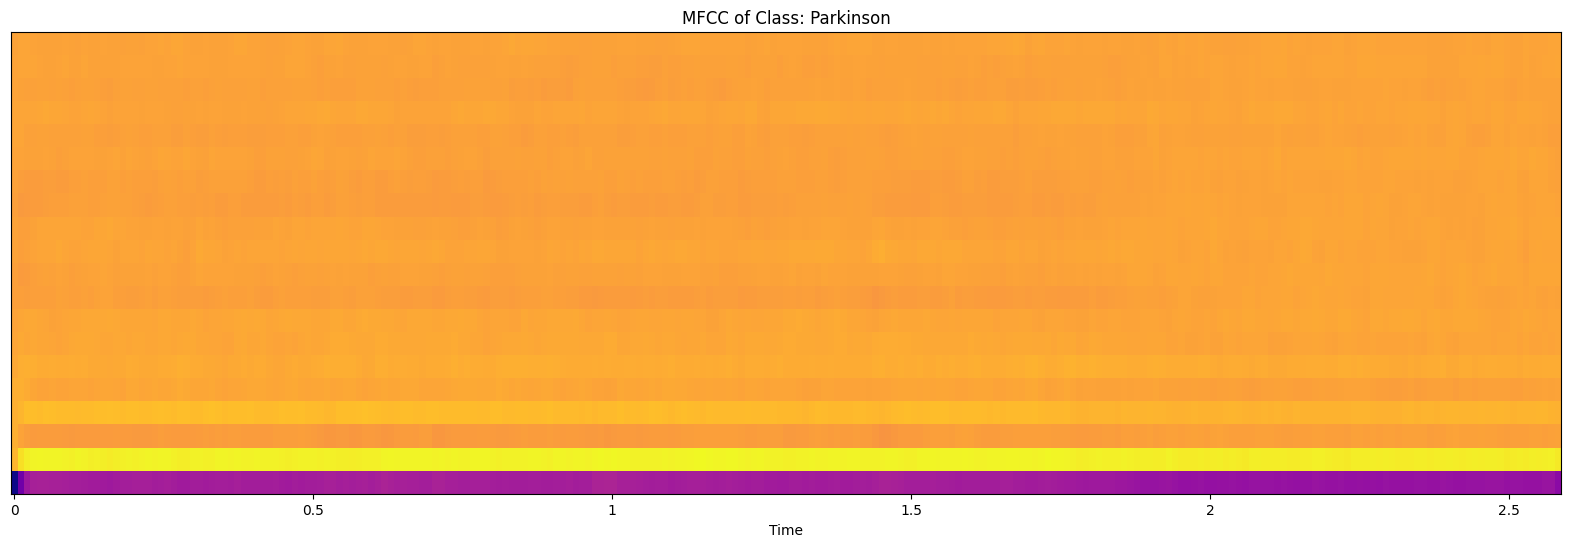

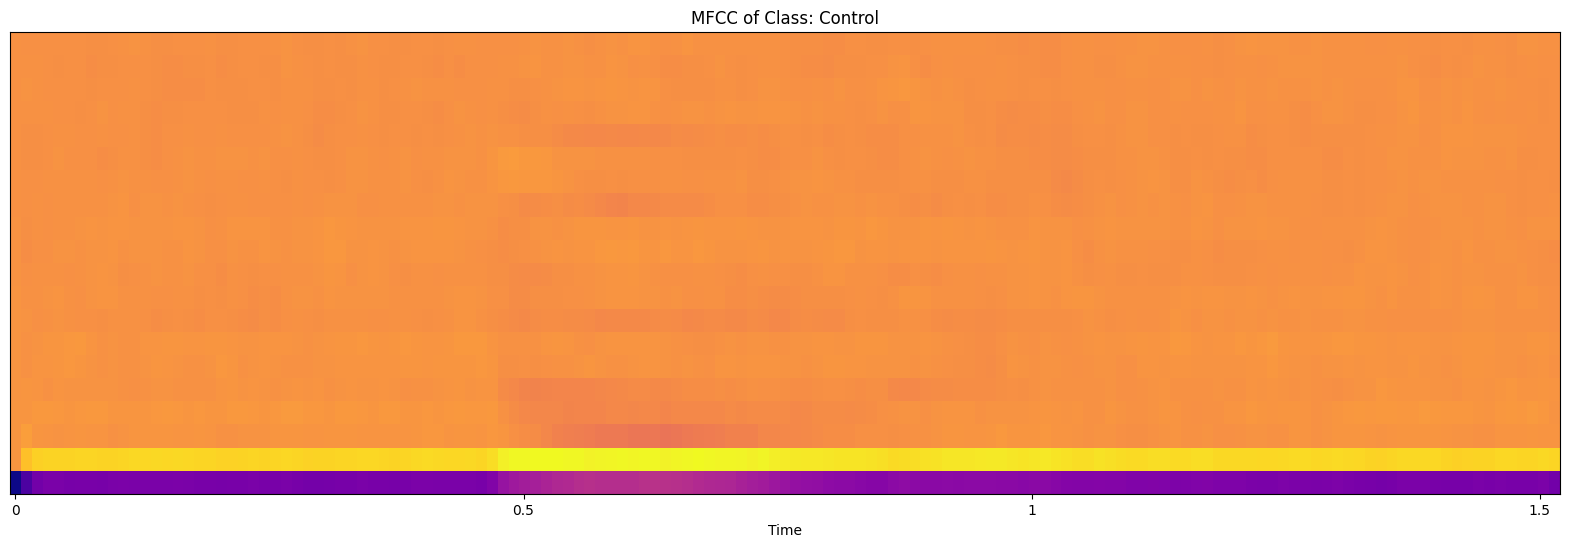

In [ ]:
show_mfccs(parkinson[0], parkinson[2])
show_mfccs(control[0], control[2])

#### **Mel Spectrogram**


*   Los patrones en los espectrogramas Mel de las muestras disártricas son algo indicativos de los arrastres en el habla.



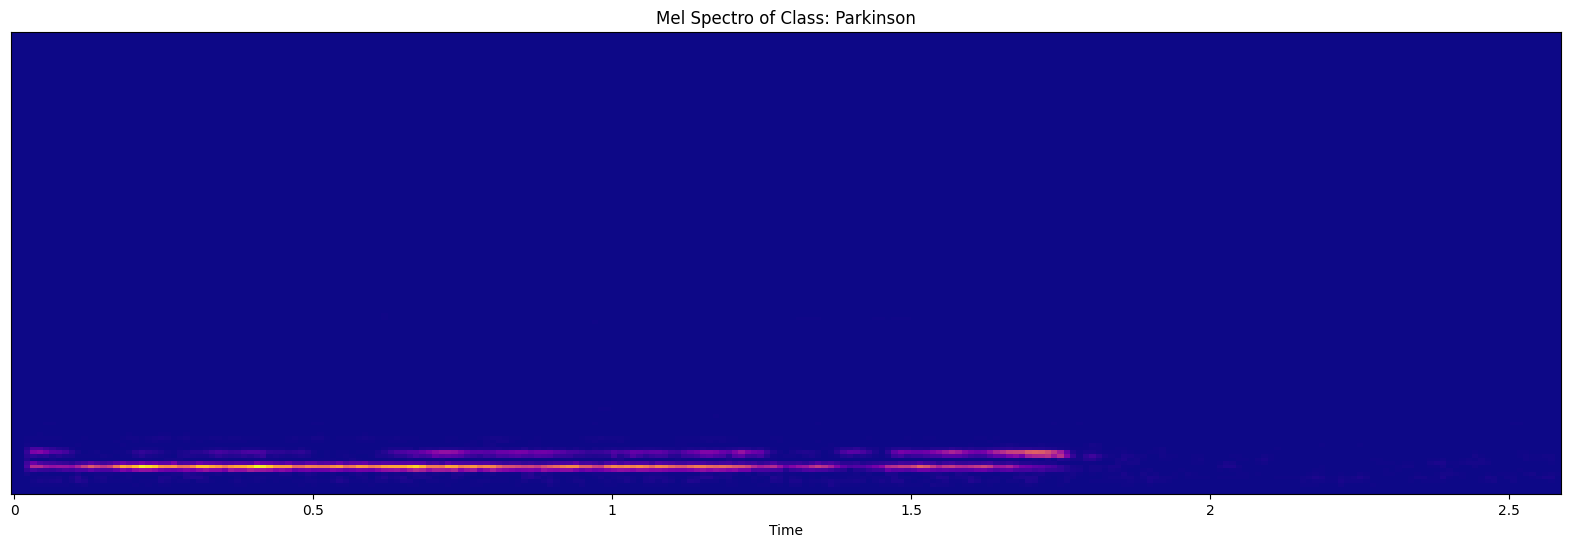

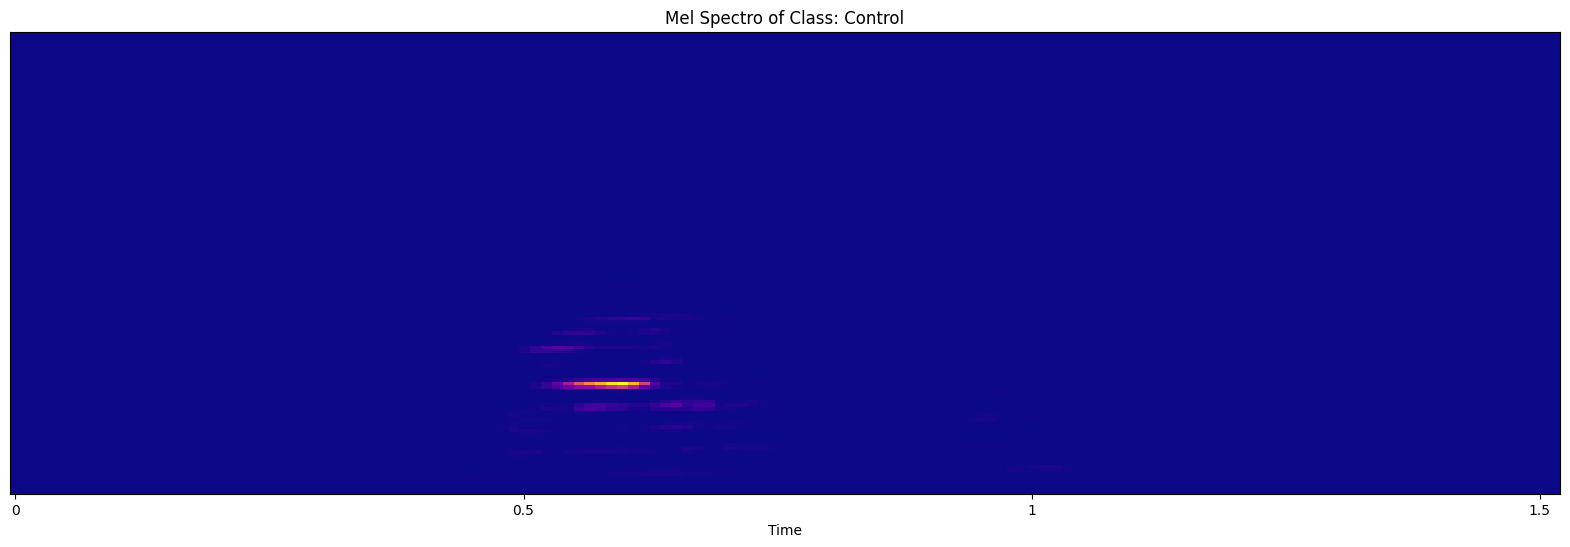

In [ ]:
show_melspectro(parkinson[0], parkinson[2])
show_melspectro(control[0], control[2])

### <font color="52F17F"> **1.2.2 Análisis de los frames para la hipomimia** </font> </font> <a name = "tema6">

Tamaño del sample con parkinson: (611, 518, 3)
Tamaño del sample de control: (689, 522, 3)


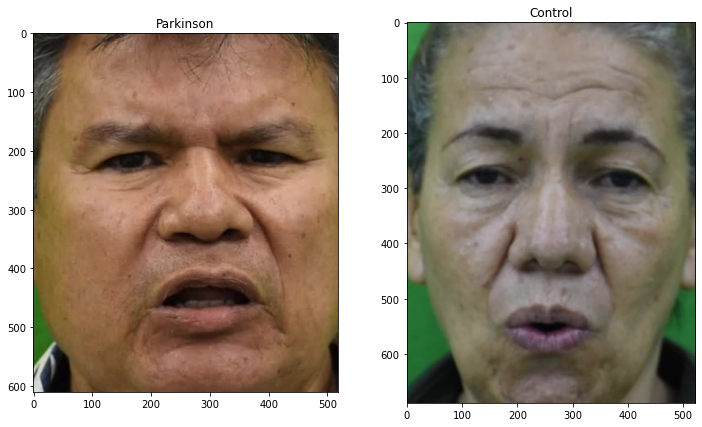

In [ ]:
#@title **Visualización de ambos frames**

# Parkinson
frame_parkinson = cv2.imread(f'{parkinson[1]}/000001.jpg')
frame_parkinson = cv2.cvtColor(frame_parkinson, cv2.COLOR_BGR2RGB)

# Control
frame_control = cv2.imread(f'{control[1]}/000001.jpg')
frame_control = cv2.cvtColor(frame_control, cv2.COLOR_BGR2RGB)

print("Tamaño del sample con parkinson:", frame_parkinson.shape)
print("Tamaño del sample de control:", frame_control.shape)

plt.figure(figsize=(12, 7))
plt.subplot(1,2,1); plt.title(parkinson[2])
plt.imshow(frame_parkinson)
plt.subplot(1,2,2); plt.title(control[2])
plt.imshow(frame_control)
plt.show()

#  <font color='#4C5FDA'> **2. Bibliografía**</font>

* librosa.stft — librosa 0.10.2dev documentation. (n.d.). https://librosa.org/doc/main/generated/librosa.stft.html
* Poojag. (2022, 14 agosto). Dysarthria Speech Classification using CNN. Kaggle. https://www.kaggle.com/code/poojag718/dysarthria-speech-classification-using-cnn









#  <font color='#4C5FDA'> **Anexos**</color>

## <font color='#EB9A54'>**Datasets adicionales. Torgo database (disartria) y datos faciales**</font>

Torgo database: https://www.kaggle.com/datasets/iamhungundji/dysarthria-detection

Facial data:

In [ ]:
data_facial.sample(frac=1).reset_index(drop=True,inplace=True)
sample_video = data_facial[(data_facial['gender']=='FEMALE')].sample(1)

In [ ]:
ipd.Video(f'facial_data/live_videos/{sample_video.iloc[0].assignment_id}.mp4', embed=True)

###**Obteniendo muestras de vídeo**

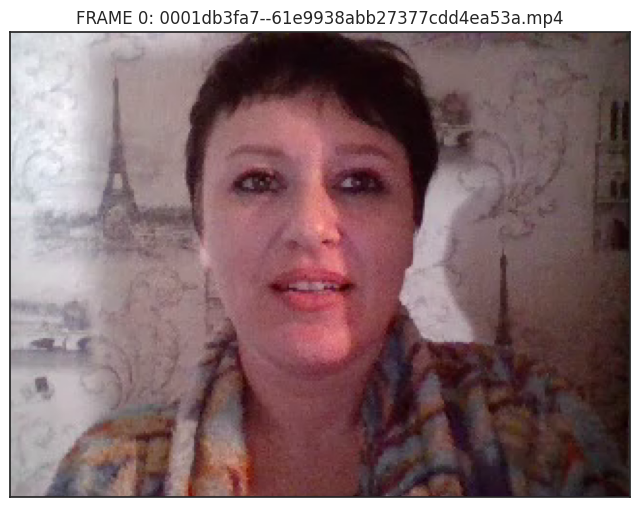

In [ ]:
#@title Consiguiendo el primer frame de nuestro vídeo
fig, ax = plt.subplots(1,1, figsize=(8, 8))
video_file = f'facial_data/live_videos/{sample_video.iloc[0].assignment_id}.mp4'
cap = cv.VideoCapture(video_file) #  Abre el archivo de vídeo para su lectura
success, image = cap.read() # Lee el primer fotograma del vídeo
image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # OpenCV a Matplotlib
cap.release() # Liberar recursos de la memoria
ax.imshow(image)
# Se ocultan los ejes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.title.set_text(f"FRAME 0: {video_file.split('/')[-1]}") # Título del plot
plt.grid(False) # Ocultar las cuadriculas

In [ ]:
data_disartria = pd.read_csv("torgo_data/data.csv")
data_facial = pd.read_csv("facial_data/file_info.csv")

In [ ]:
print(data_disartria.shape, data_facial.shape)
data_disartria.head()
# data.describe()


(2000, 3) (7, 6)


is_dysarthria  gender                                           filename
0  non_dysarthria  female  torgo_data/non_dysarthria_female/FC03_Session2...
1  non_dysarthria  female  torgo_data/non_dysarthria_female/FC02_Session3...
2  non_dysarthria  female  torgo_data/non_dysarthria_female/FC02_Session3...
3  non_dysarthria  female  torgo_data/non_dysarthria_female/FC03_Session2...
4  non_dysarthria  female  torgo_data/non_dysarthria_female/FC03_Session1...

In [ ]:
data_facial.head()

assignment_id                         worker_id  \
0  0001d815c0--61dc3cd237bb0b17026609ea  e4dfe8860e51162b9887d1a14b2b5ba0   
1  0001d815c0--61e409908ccae11700e6a347  458fe395c77c079fba013b9b080bd054   
2  0001d815c0--61e561016090114967d86569  3fe8c977f4c80af79424c656f0175e37   
3  0001d815c0--61eeaf9928213259ef95a20a  e8ed3792b8a0c3193c165c3875bbfb65   
4  0001d815c0--61f3c3321e087a11af822fdc  1624db9d89e26abd544dd160ef7b2d87   

   gender  age country     resolution  
0  FEMALE   41      PL  240.0 x 320.0  
1  FEMALE   45      RU  120.0 x 160.0  
2    MALE   45      RU  120.0 x 160.0  
3  FEMALE   20      RU  120.0 x 160.0  
4    MALE   28      RU  144.0 x 176.0

In [ ]:
#@title Observar las caractreísticas de cada varibale
data_disartria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   is_dysarthria  2000 non-null   object
 1   gender         2000 non-null   object
 2   filename       2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


In [ ]:
data_facial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   assignment_id  7 non-null      object
 1   worker_id      7 non-null      object
 2   gender         7 non-null      object
 3   age            7 non-null      int64 
 4   country        7 non-null      object
 5   resolution     7 non-null      object
dtypes: int64(1), object(5)
memory usage: 464.0+ bytes


## <font color='#EB9A54'>**Face recognition and landmarks**</font>

Now lets use opencv to detect the faces using the face_recognition package! First we need to pip install it. Make sure you have internet turned on in your kernel.

Reference: https://github.com/ageitgey/face_recognition

In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=f16c47bebceac85f71a6d734ad226d0d048a80f683edf1e4706abcf31aa75957
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


I found 1 face(s) in this photograph.
A face is located at pixel location Top: 106, Left: 126, Bottom: 196, Right: 215


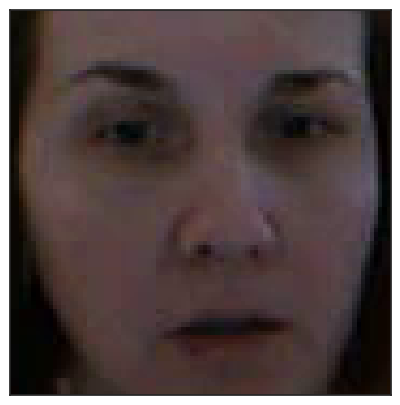

In [ ]:
import face_recognition
face_locations = face_recognition.face_locations(image)

# https://github.com/ageitgey/face_recognition/blob/master/examples/find_faces_in_picture.py
from PIL import Image

print("I found {} face(s) in this photograph.".format(len(face_locations)))

for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    # You can access the actual face itself like this:
    face_image = image[top:bottom, left:right]
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    plt.grid(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(face_image)

###**Locating a face landmarks within an image**

In [ ]:
face_landmarks_list = face_recognition.face_landmarks(image)

The chin in this face has the following points: [(127, 134), (128, 147), (131, 160), (135, 172), (141, 183), (148, 193), (158, 200), (168, 206), (179, 207), (188, 204), (195, 197), (201, 188), (206, 178), (208, 167), (210, 156), (212, 144), (212, 133)]
The left_eyebrow in this face has the following points: [(137, 125), (143, 120), (150, 118), (158, 120), (165, 124)]
The right_eyebrow in this face has the following points: [(184, 124), (190, 120), (197, 119), (203, 120), (207, 124)]
The nose_bridge in this face has the following points: [(176, 134), (177, 142), (178, 150), (179, 158)]
The nose_tip in this face has the following points: [(168, 164), (173, 165), (178, 166), (182, 165), (185, 163)]
The left_eye in this face has the following points: [(146, 135), (151, 132), (157, 132), (162, 136), (157, 137), (151, 138)]
The right_eye in this face has the following points: [(185, 136), (190, 132), (196, 131), (200, 134), (196, 136), (191, 137)]
The top_lip in this face has the following p

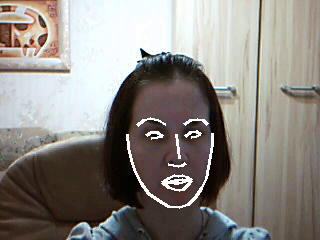

In [ ]:
# https://github.com/ageitgey/face_recognition/blob/master/examples/find_facial_features_in_picture.py
# face_landmarks_list
from PIL import Image, ImageDraw
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)

for face_landmarks in face_landmarks_list:

    # Print the location of each facial feature in this image
    for facial_feature in face_landmarks.keys():
        print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))

    # Let's trace out each facial feature in the image with a line!
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=3)

# Show the picture
display(pil_image)

###**Displaying many test examples and labels**

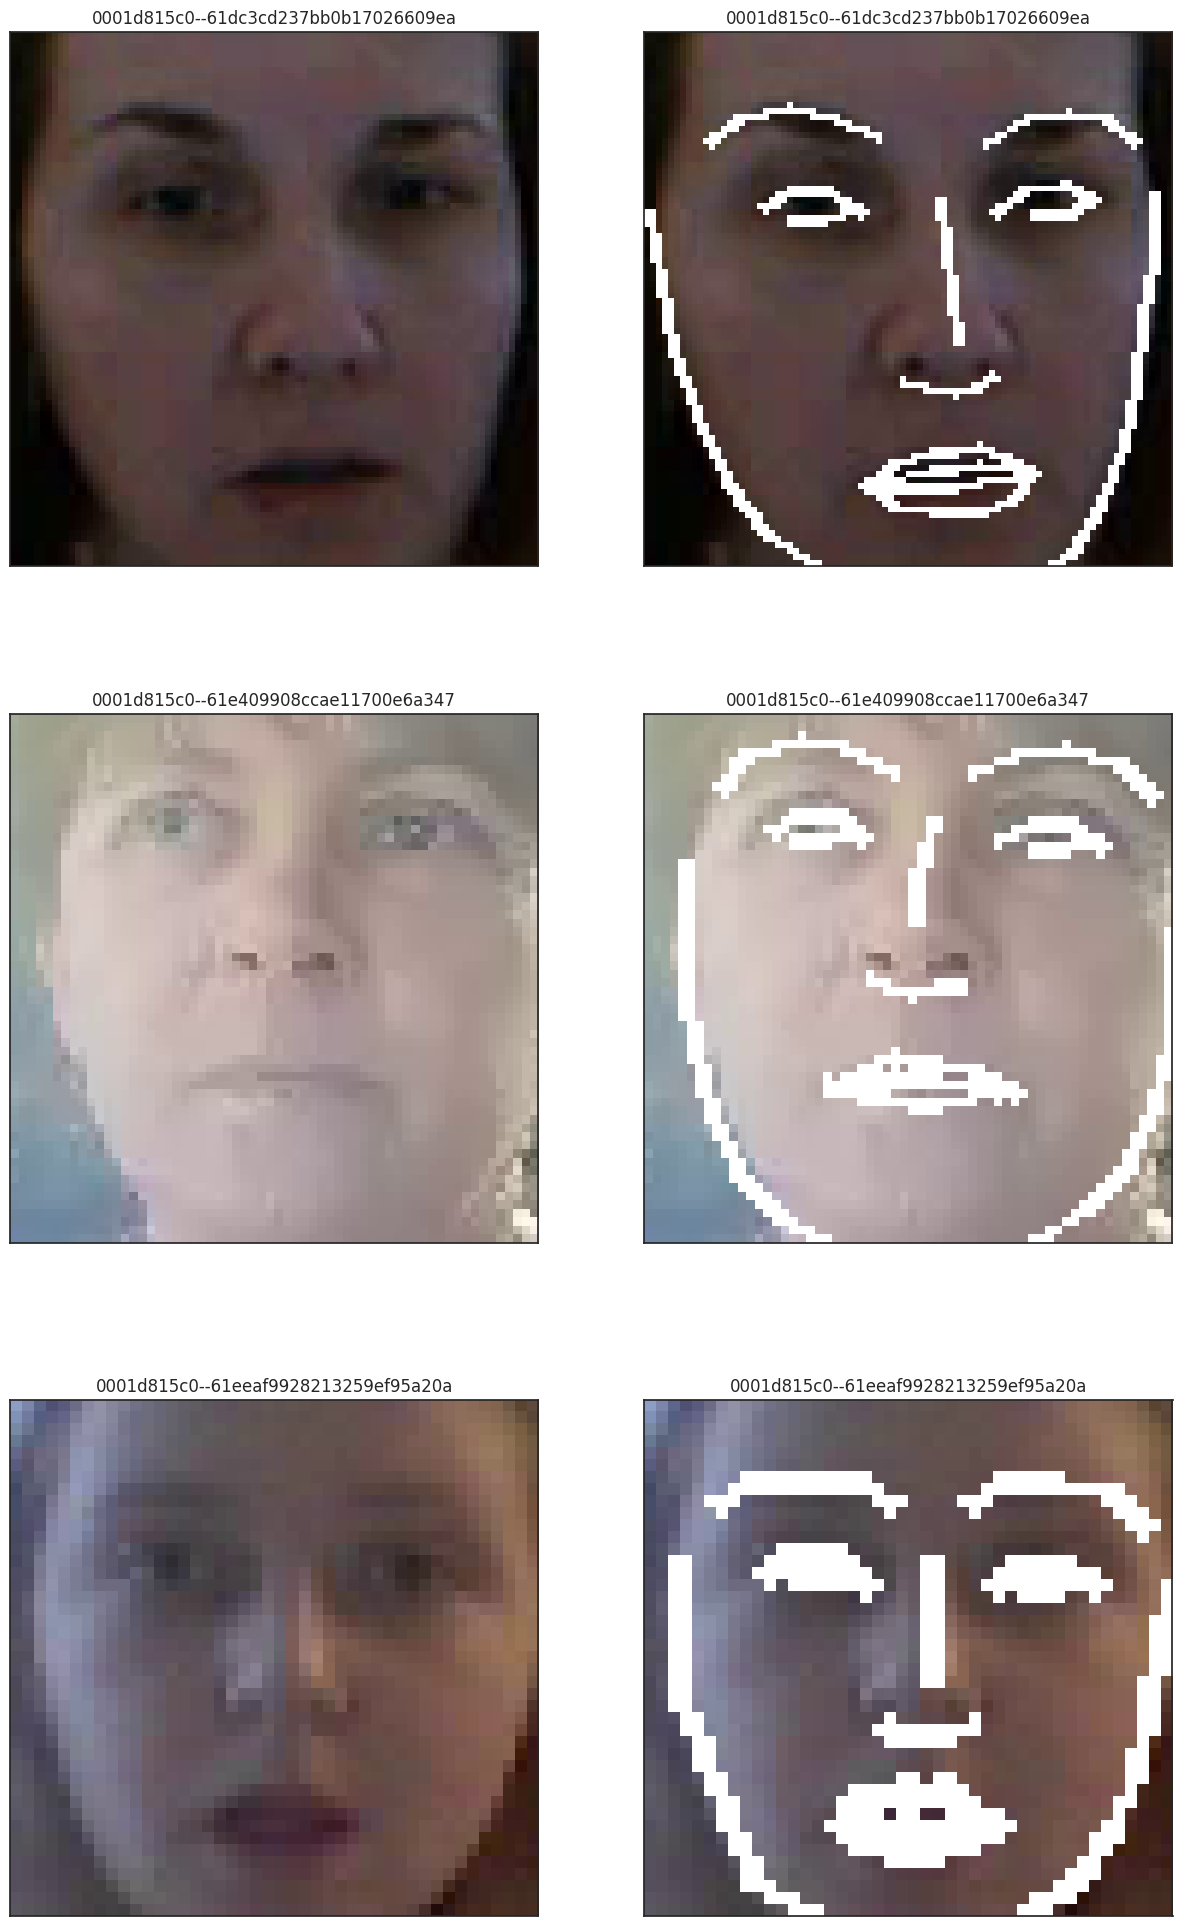

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 25))
axs = np.array(axs)
axs = axs.reshape(-1)
i = 0
for fn in data_facial.assignment_id[:4]:
    # label = data_facial.iloc[fn]['worker_id']
    # orig = data_facial.loc[fn]['label']
    video_file = f'facial_data/live_videos/{fn}.mp4'
    ax = axs[i]
    cap = cv.VideoCapture(video_file)
    success, image = cap.read()
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    face_locations = face_recognition.face_locations(image)
    if len(face_locations) > 0:
        # Print first face
        face_location = face_locations[0]
        top, right, bottom, left = face_location
        face_image = image[top:bottom, left:right]
        ax.imshow(face_image)
        ax.grid(False)
        # ax.title.set_text(f'{fn} - {label}')
        ax.title.set_text(f'{fn}')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        # Find landmarks
        face_landmarks_list = face_recognition.face_landmarks(face_image)
        face_landmarks = face_landmarks_list[0]
        pil_image = Image.fromarray(face_image)
        d = ImageDraw.Draw(pil_image)
        for facial_feature in face_landmarks.keys():
            d.line(face_landmarks[facial_feature], width=2)
        landmark_face_array = np.array(pil_image)
        ax2 = axs[i+1]
        ax2.imshow(landmark_face_array)
        ax2.grid(False)
        # ax2.title.set_text(f'{fn} - {label}')
        ax2.title.set_text(f'{fn}')
        ax2.xaxis.set_visible(False)
        ax2.yaxis.set_visible(False)
        i += 2
plt.grid(False)
plt.show()

## <font color='#EB9A54'>**Extra: Manejo de archivos (imágenes y audio)**</font>

In [ ]:
#@title Código para renombrar archivos que no coinciden con el paciente el ID
def rename_files_based_on_id(base_path):
    """
    Rename audio and frame files based on the correct patient ID.

    Args:
    - base_path (str): Path to the root directory of the dataset.

    Returns:
    - None
    """

    # Lista de pacientes con IDs incorrectos
    correct_ids = ['C4', 'C5', 'C6']

    # Iterar sobre los pacientes
    for patient_type in ['Control', 'Parkinson']:
      for correct_id in correct_ids:

          # Construir las rutas originales
          original_path = os.path.join(base_path, patient_type, correct_id)

          # Verificar si el directorio existe
          if not os.path.exists(original_path):
              print(f"No directory found for {correct_id} in {patient_type}.")
              continue

          # Obtener el ID correcto para el paciente
          correct_id = f"{patient_type[0]}{int(correct_id[1:])}"

          # Construir la ruta del nuevo directorio
          new_path = os.path.join(base_path, patient_type, correct_id)


          # # Renombrar los directorios
          # os.rename(original_path, new_path)

          # print(f"Renamed {patient_type} directory from {incorrect_id} to {correct_id}.")

          # Iterar sobre las categorías (Phonemes, Vowels, Words)
          for category in ['Phonemes', 'Vowels', 'Words']:

              original_category_path = os.path.join(new_path, category)

              # Verificar si el directorio de la categoría existe
              if not os.path.exists(original_category_path):
                  print(f"No {category} directory found for {correct_id}.")
                  continue

              # Iterar sobre los archivos en la carpeta original
              for file_type in os.listdir(original_category_path):

                  # Construir los nombres de los archivos originales y nuevos
                  original_file_path = os.path.join(original_category_path, file_type)
                  # new_file_name = file_name.replace(incorrect_id, correct_id)
                  # new_file_path = os.path.join(original_category_path, incorrect_id)
                  for file_name in os.listdir(original_file_path):
                    actual_file_name_path = os.path.join(original_file_path, file_name)
                    new_file_name = file_name.replace(file_name[:2], correct_id)
                    new_file_name_path = os.path.join(original_file_path, new_file_name)
                    # print(f"{actual_file_name_path} - {new_file_name_path}")

                  # Renombrar los archivos
                    os.rename(actual_file_name_path, new_file_name_path)

                    print(f"Renamed {category} file from {file_name} to {new_file_name}.")

# Llamar a la función para corregir los nombres de los archivos
rename_files_based_on_id("AudioVisualData_v7")

Renamed Phonemes file from C4-2-Pakata.mp3 to C4-2-Pakata.mp3.
Renamed Phonemes file from C4-2-Petaka.mp3 to C4-2-Petaka.mp3.
Renamed Phonemes file from C4-2-Pataka.mp3 to C4-2-Pataka.mp3.
Renamed Phonemes file from C4-3-Petaka.mp3 to C4-3-Petaka.mp3.
Renamed Phonemes file from C4-3-Pataka.mp3 to C4-3-Pataka.mp3.
Renamed Phonemes file from C4-1-Pakata.mp3 to C4-1-Pakata.mp3.
Renamed Phonemes file from C4-1-Pataka.mp3 to C4-1-Pataka.mp3.
Renamed Phonemes file from C4-1-Petaka.mp3 to C4-1-Petaka.mp3.
Renamed Phonemes file from C4-3-Pakata.mp3 to C4-3-Pakata.mp3.
Renamed Phonemes file from C4-3-Pataka.mov to C4-3-Pataka.mov.
Renamed Phonemes file from C4-3-Petaka.mov to C4-3-Petaka.mov.
Renamed Phonemes file from C4-3-Pakata.mov to C4-3-Pakata.mov.
Renamed Phonemes file from C4-1-Petaka.mov to C4-1-Petaka.mov.
Renamed Phonemes file from C4-2-Pakata.mov to C4-2-Pakata.mov.
Renamed Phonemes file from C4-2-Pataka.mov to C4-2-Pataka.mov.
Renamed Phonemes file from C4-2-Petaka.mov to C4-2-Peta

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')
# Esta es una carpeta en mi drive
%cd /content/gdrive/MyDrive/semilleroEstudiantes/introducción a python

Mounted at /content/gdrive/
/content/gdrive/MyDrive/semilleroEstudiantes/introducción a python


### Imágenes

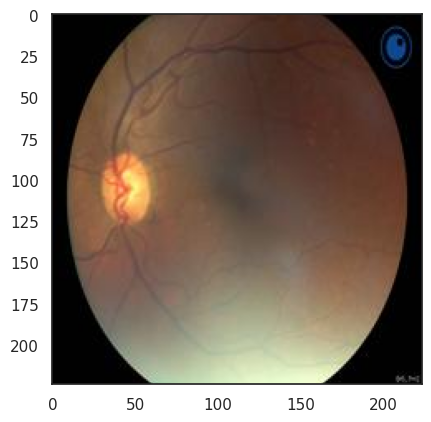

In [ ]:
#@title Mostrando imágenes con PIL y Matplotlib


# import matplotlib.pyplot as plt
# import numpy as np
# from PIL import Image

img = np.asarray(Image.open('imagenes/IM0535EY.JPG'))
imgplot = plt.imshow(img)

Altura: 224, Ancho: 224, Canales (RGB):3


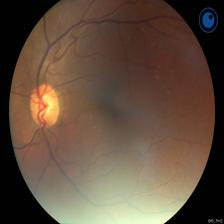

In [ ]:
#@title Mostrando imágenes con Open CV
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('imagenes/IM0535EY.JPG')
(h, w, c) = image.shape[:3]
print(f"Altura: {h}, Ancho: {w}, Canales (RGB):{c}")
cv2_imshow(image)